### Librerias a utilizar

In [883]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor




### Carga de los archivos csv.

In [884]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (912, 14)
Test shape: (391, 13)


In [885]:
train.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [886]:
test.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,181,1098,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.3kg
1,708,330,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8GB,256GB SSD,AMD Radeon RX 540,Windows 10,2.2kg
2,862,1260,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,500GB HDD,Intel HD Graphics 520,Linux,2.4kg
3,1064,1137,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.43kg
4,702,1015,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.34kg


La variable respuesta a utilizar es "price_euros" la cual no se encuentra en el dataset de testeo. Ahora se va a proceder a ver si existen valores nulos en los dataset y ver tambien el tipo de dato que contiene. 

### Análisis Descriptivo del Dataset de entrenamiento.

In [887]:
print(train.isnull().sum())
print(train.dtypes)



id                  0
laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64
id                    int64
laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object


Convertimos la variable "Weight" a float

In [888]:
def clean_weight_column(df):
    # Elimina el texto "kg", "g", etc. y convierte a float
    df['Weight'] = df['Weight'].str.replace('kg', '').str.strip()
    df['Weight'] = df['Weight'].astype(float)
    return df

train = clean_weight_column(train)
test = clean_weight_column(test)

Como se puede observar no se aprecian valores nulos en el dataset de entrenamiento, ademas dentro de las variables de dataset apreciamos muchas columnas correspondientes a valores de caracter categorico las cuales van a tener que ser convertidas a valores númericos mas adelante.

In [889]:
train.describe()


,id,laptop_ID,Inches,Weight,Price_euros
count,912.000000,912.000000,912.000000,912.000000,912.000000
mean,645.091009,666.192982,15.011404,2.032112,1108.122873
std,380.313813,384.873846,1.411744,0.653772,714.597741
min,0.000000,1.000000,10.100000,0.690000,174.000000
25%,319.750000,330.500000,14.000000,1.500000,589.000000
50%,636.500000,673.500000,15.600000,2.040000,949.000000
75%,980.250000,998.500000,15.600000,2.300000,1458.500000
max,1302.000000,1320.000000,18.400000,4.600000,6099.000000


In [890]:
test.describe()

,id,laptop_ID,Inches,Weight
count,391.000000,391.000000,391.000000,391.000000
mean,664.782609,646.074169,15.030691,2.054179
std,366.835995,372.500700,1.461446,0.692613
min,6.000000,18.000000,11.300000,0.910000
25%,344.500000,335.000000,14.000000,1.490000
50%,679.000000,629.000000,15.600000,2.050000
75%,960.000000,955.500000,15.600000,2.345000
max,1299.000000,1319.000000,17.300000,4.700000


### Limpieza de los datos

Las columnas "id" y "laptop_ID" no nos aportan información útil para predecir el precio, ya que son identificadores únicos sin relación directa con las características técnicas o el valor del portátil. Por tanto, las eliminamos.

In [891]:

train = train.drop(['id', 'laptop_ID'], axis=1)
test = test.drop(['id', 'laptop_ID'], axis=1)

Debidio a la alta cardinalidad de algunas de las variables yt la existencia de muchos valores unicos (sobre todo las categoricas) vamos a separar las columnas en base a su tipo y realizamos el analisis grafico correspondiente

In [892]:
columnas_numericas = train.select_dtypes(include=['int64', 'float64']).columns
columnas_categoricas = train.select_dtypes(include='object').columns

### Histograma y Boxplot para las variables numericas

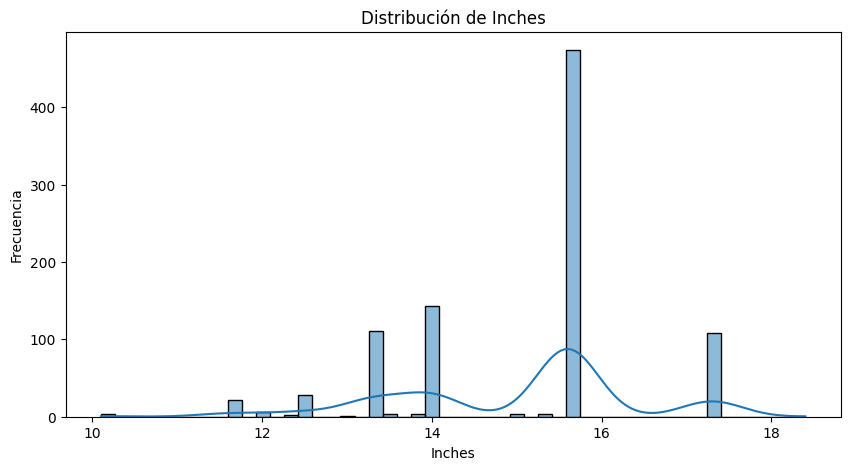

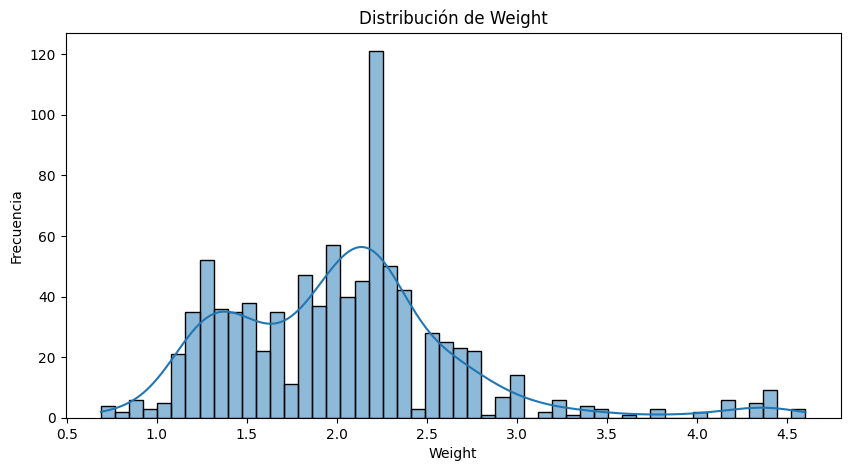

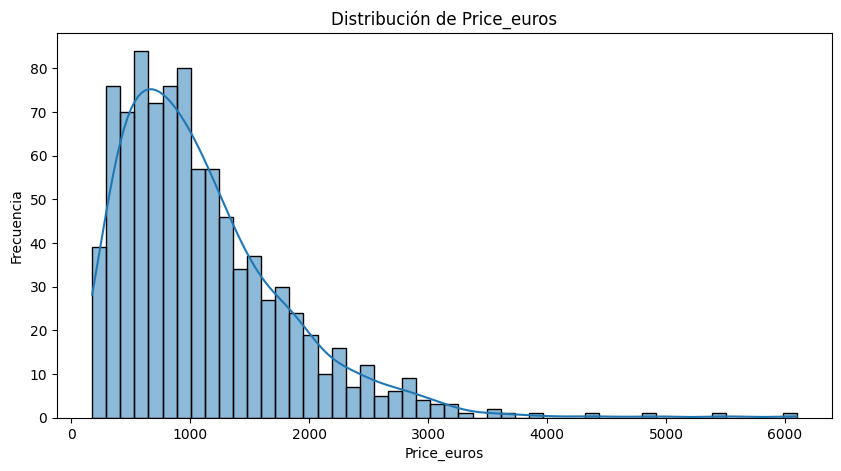

In [893]:
for col in columnas_numericas:
    plt.figure(figsize=(10, 5))
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()


Para peso si que podemos observar una distribucion aparentemente normal, aunque con una evidente bimodalidad. Podemos entender que los portatiles con menor peso corresponden a ciertos productos con unas caracteristicas concretas y que interesa que sean lo mas ligero posible (Notebooks), pero que la mayoria se encuentra en un rango entre los 2 y 3 kgs. Por otro lado la presencia de una larga cola a la derecha parece indicarnos tambien que los portatiles con un peso de 4kgs u mas puedan pertenecer a un grupo con unas caracteristicas mas concretas (una mayor potenciua gráfica para Gaming o directamente una Workstation)

Centrandonos principalmente en nuestra variable respuesta, podemos observar que tiene una distribución claramente asimétrica positiva, con una alta concentración de precios en el rango de 300 a 1500 euros, siendo este el intervalo donde se encuentran la mayoría de los datos. A partir de ahí, la frecuencia va disminuyendo gradualmente, formando una cola larga hacia la derecha que incluye algunos precios significativamente más altos, incluso por encima de los 4000 o 5000 euros, lo que indica la presencia de algun que otro valor atípicos.

Esta forma de distribución sugiere que la media del precio será mayor que la mediana, lo cual es típico en datos sesgados hacia la derecha. Lo que puede influirnos en ciertos análisis estadísticos. Además, sería útil explorar estos valores extremos para decidir si deben ser tratados como outliers o si representan casos válidos dentro del contexto del estudio.

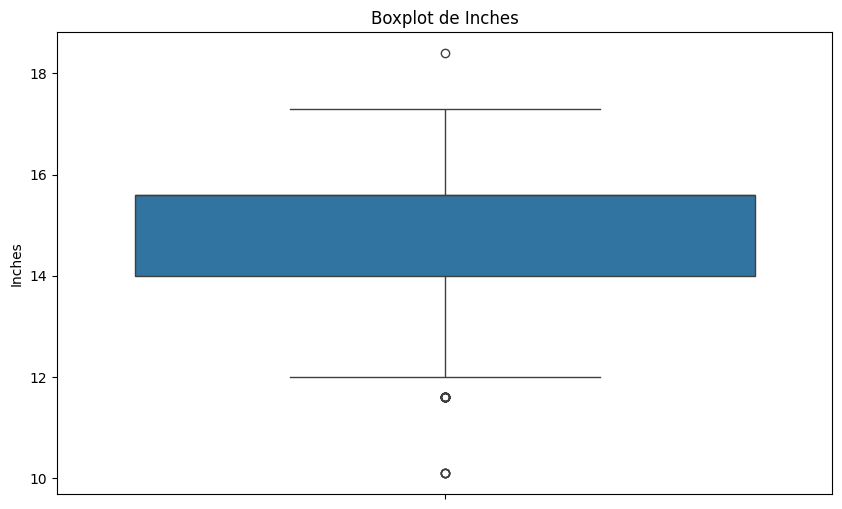

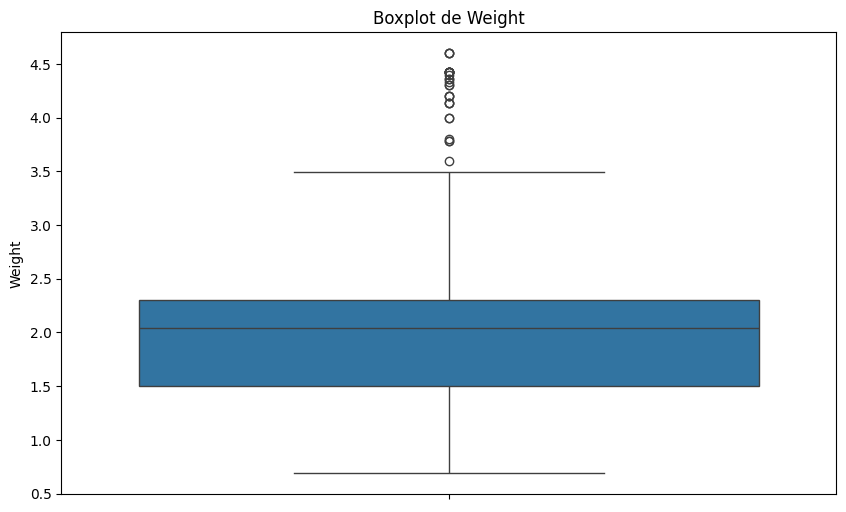

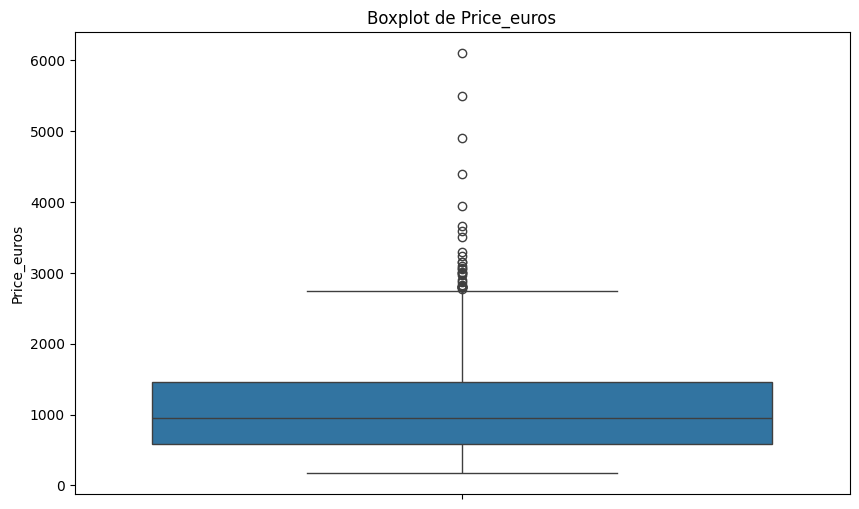

In [894]:
for col in columnas_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=train[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

Observando los boxplots de variables numéricas del dataset, se observaron varios outliers para todas las columnas. Estos valores extremos corresponden a configuraciones reales de portátiles, desde modelos básicos hasta equipos premium con pantallas grandes, mucha memoria y componentes avanzados, lo que justifica su presencia. Mantener estos outliers es importante para que el modelo capture toda la diversidad del mercado, por lo que no los eliminaremos. 

### Gráfico de barras para variables categóricas. 

Para estas variables, debido a la existencia de  valores únicos en varias de las columnas, que nos generan ejes con etiquetas ilegibles y gráficos sin sentido. Vamos a proceder mostrando unicamente las 15 categorías más frecuentes:


C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


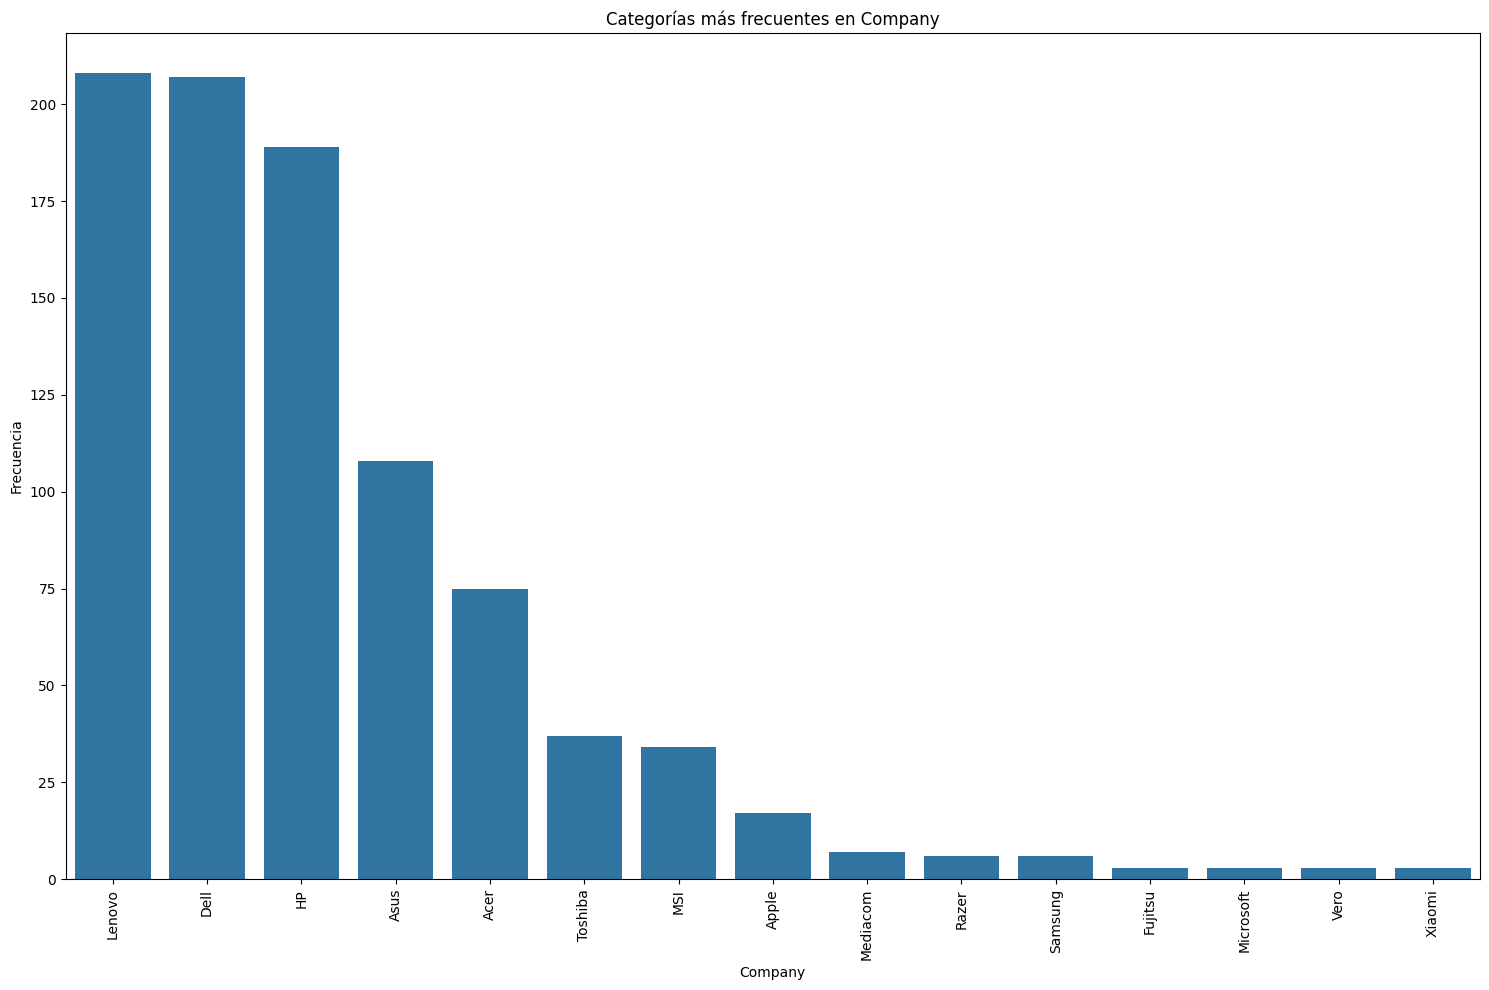

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


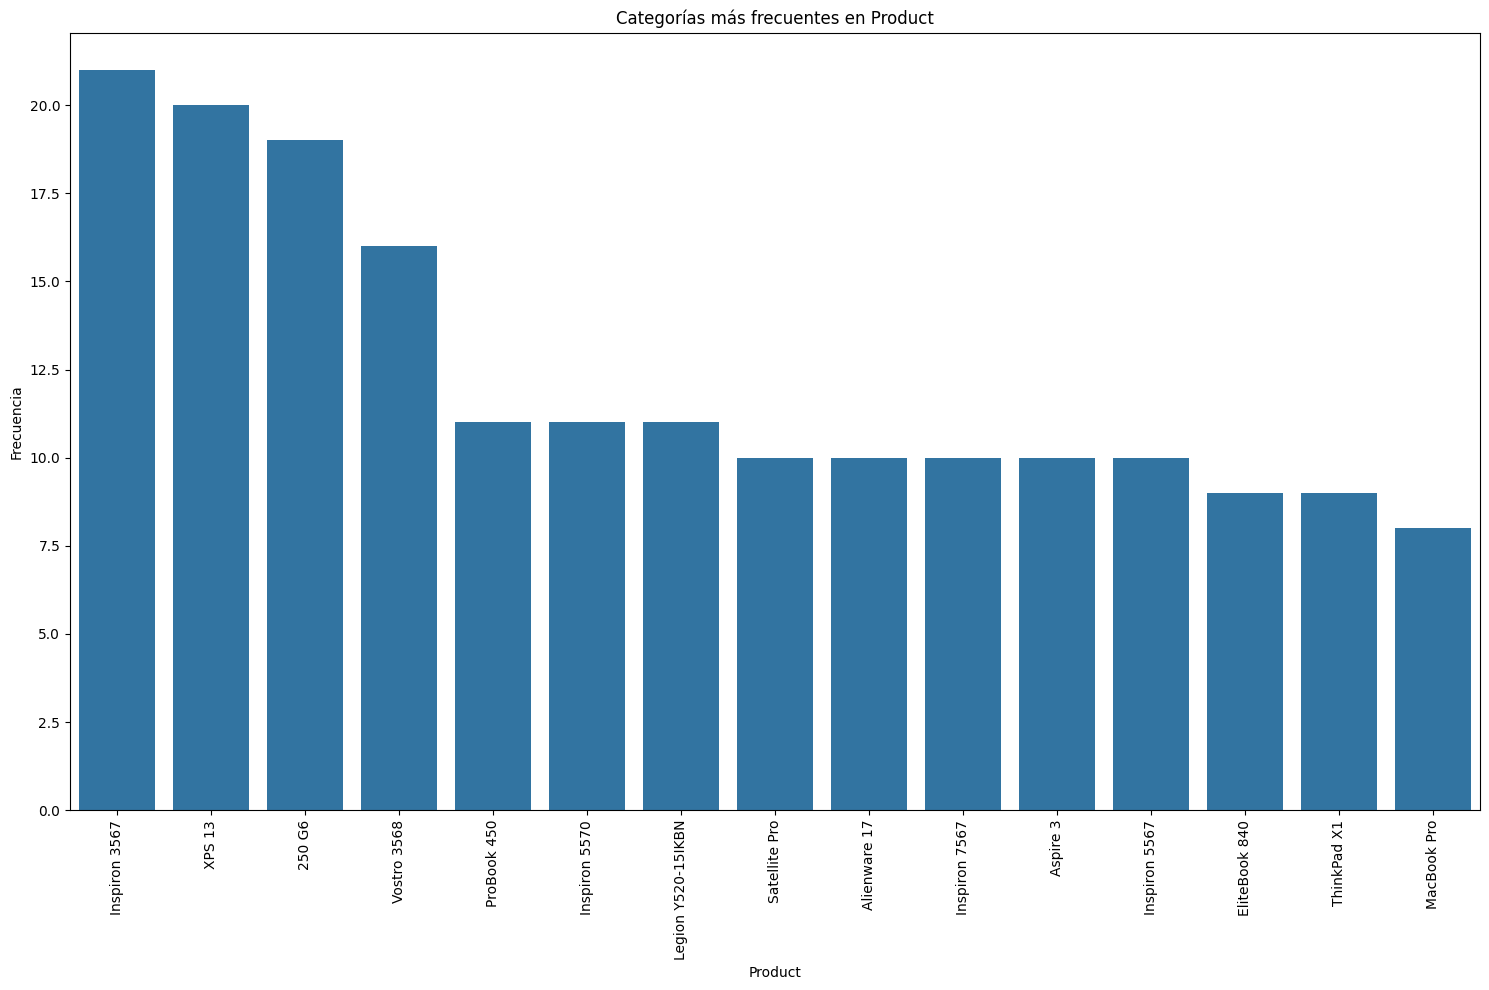

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


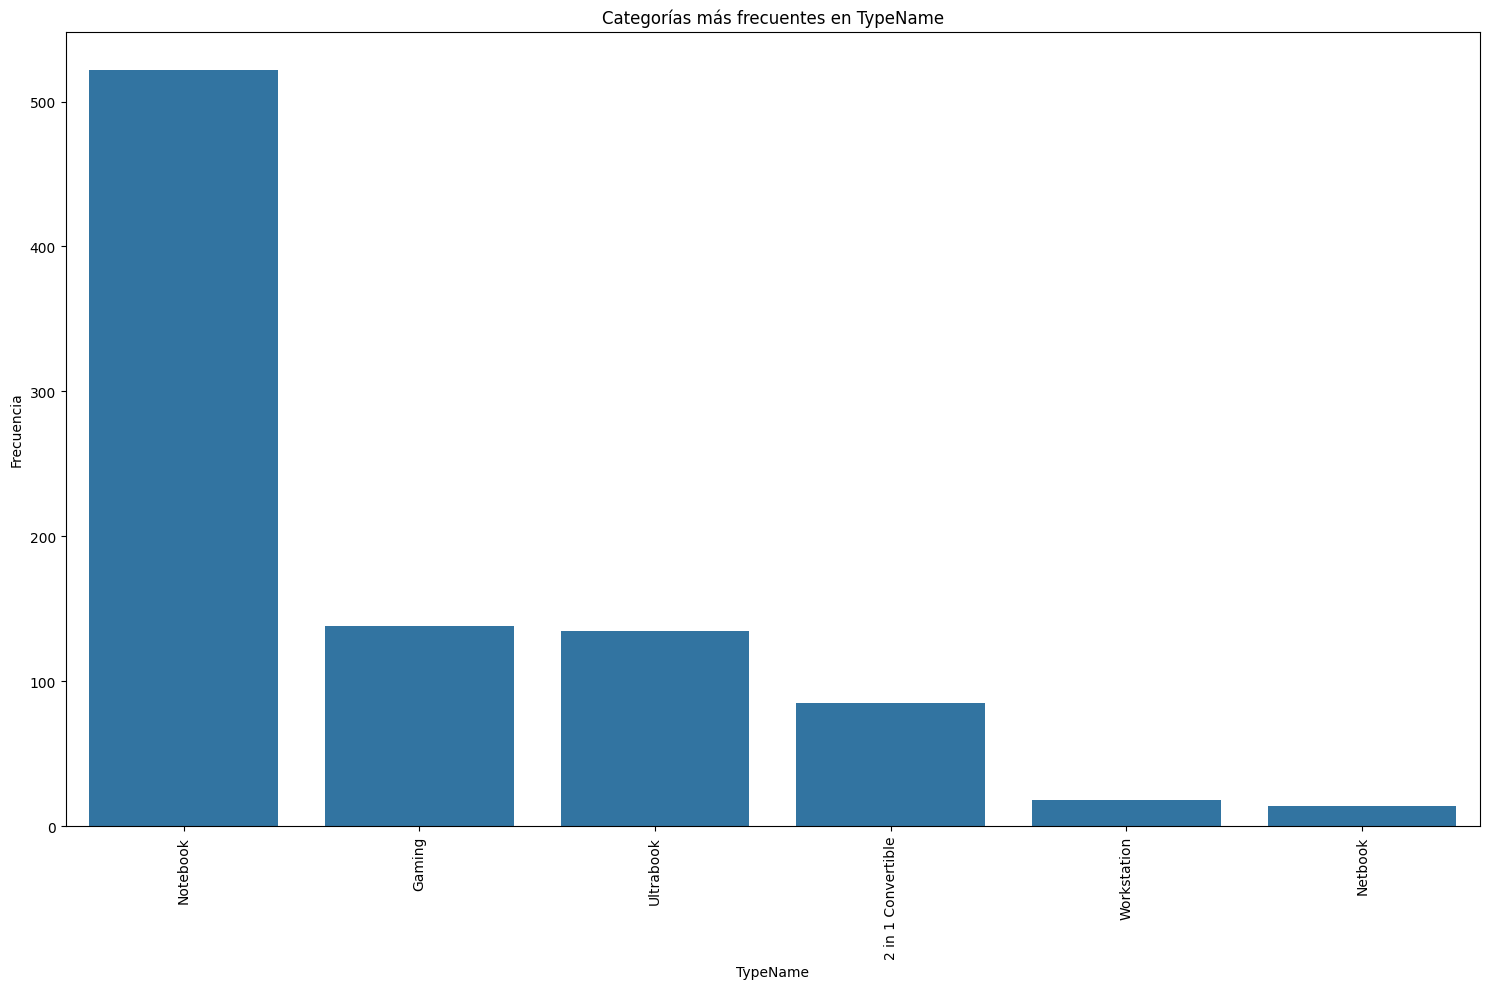

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


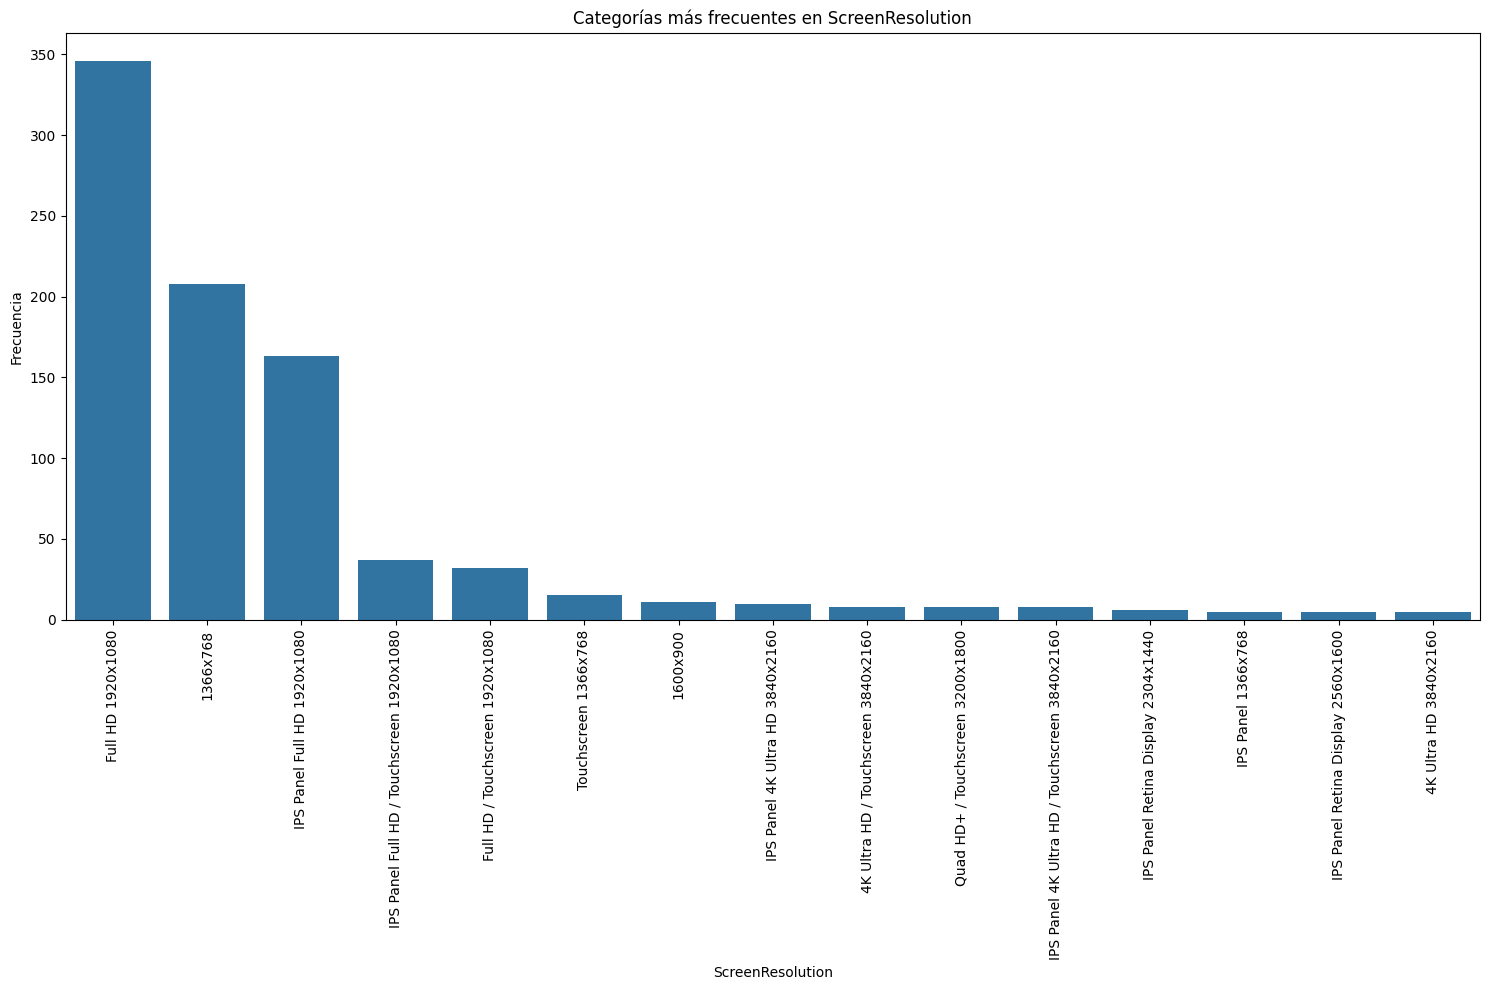

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


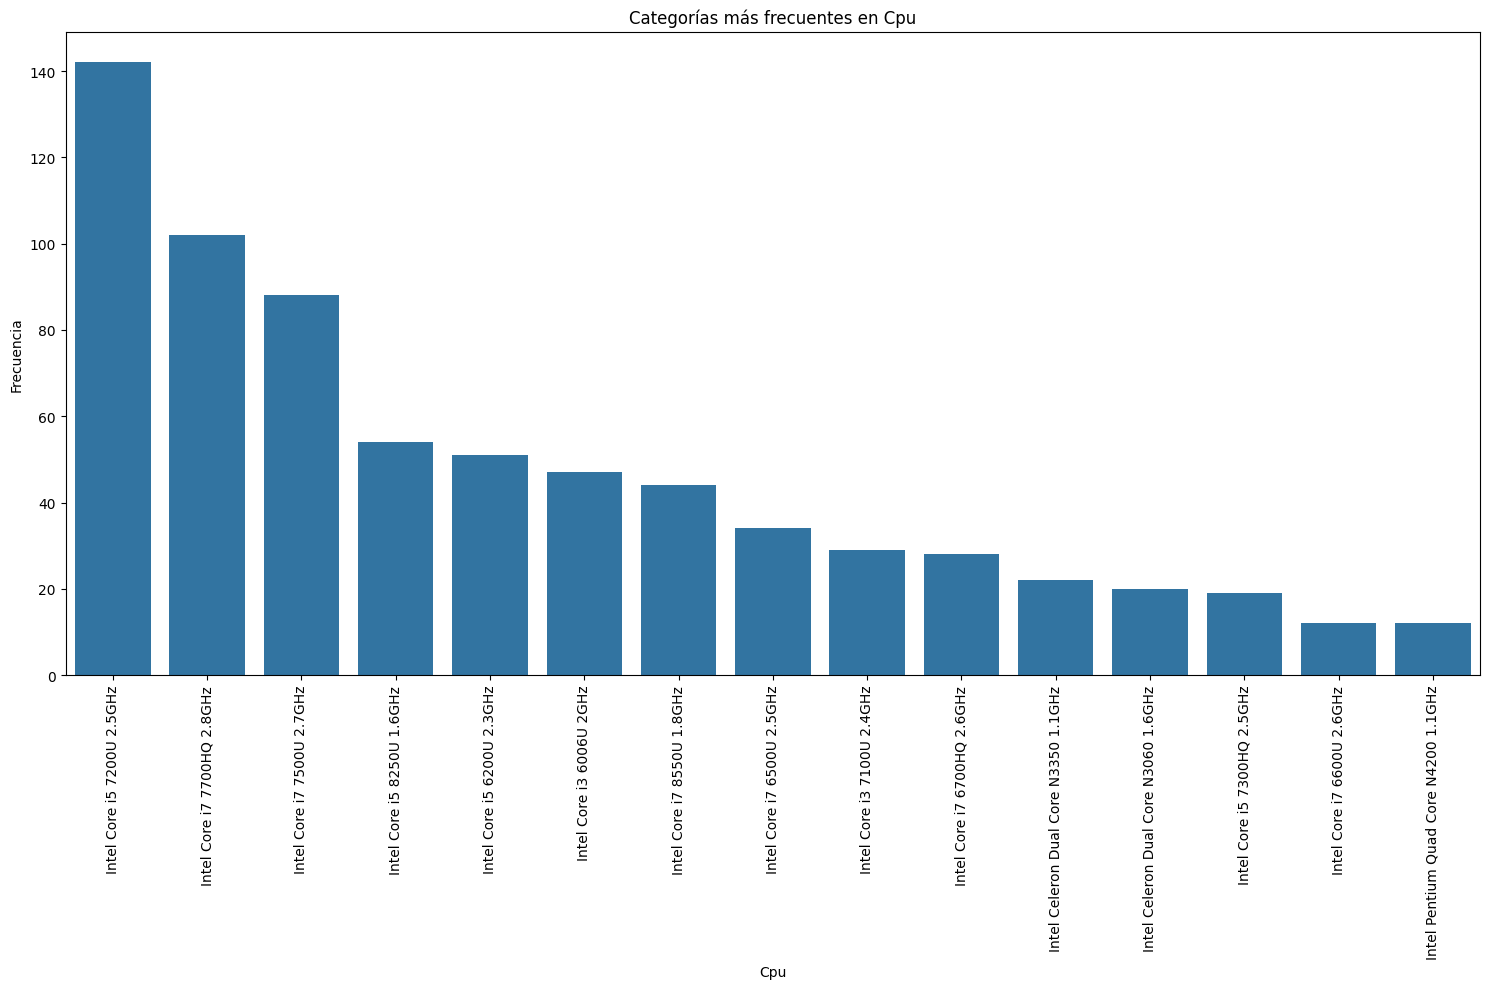

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


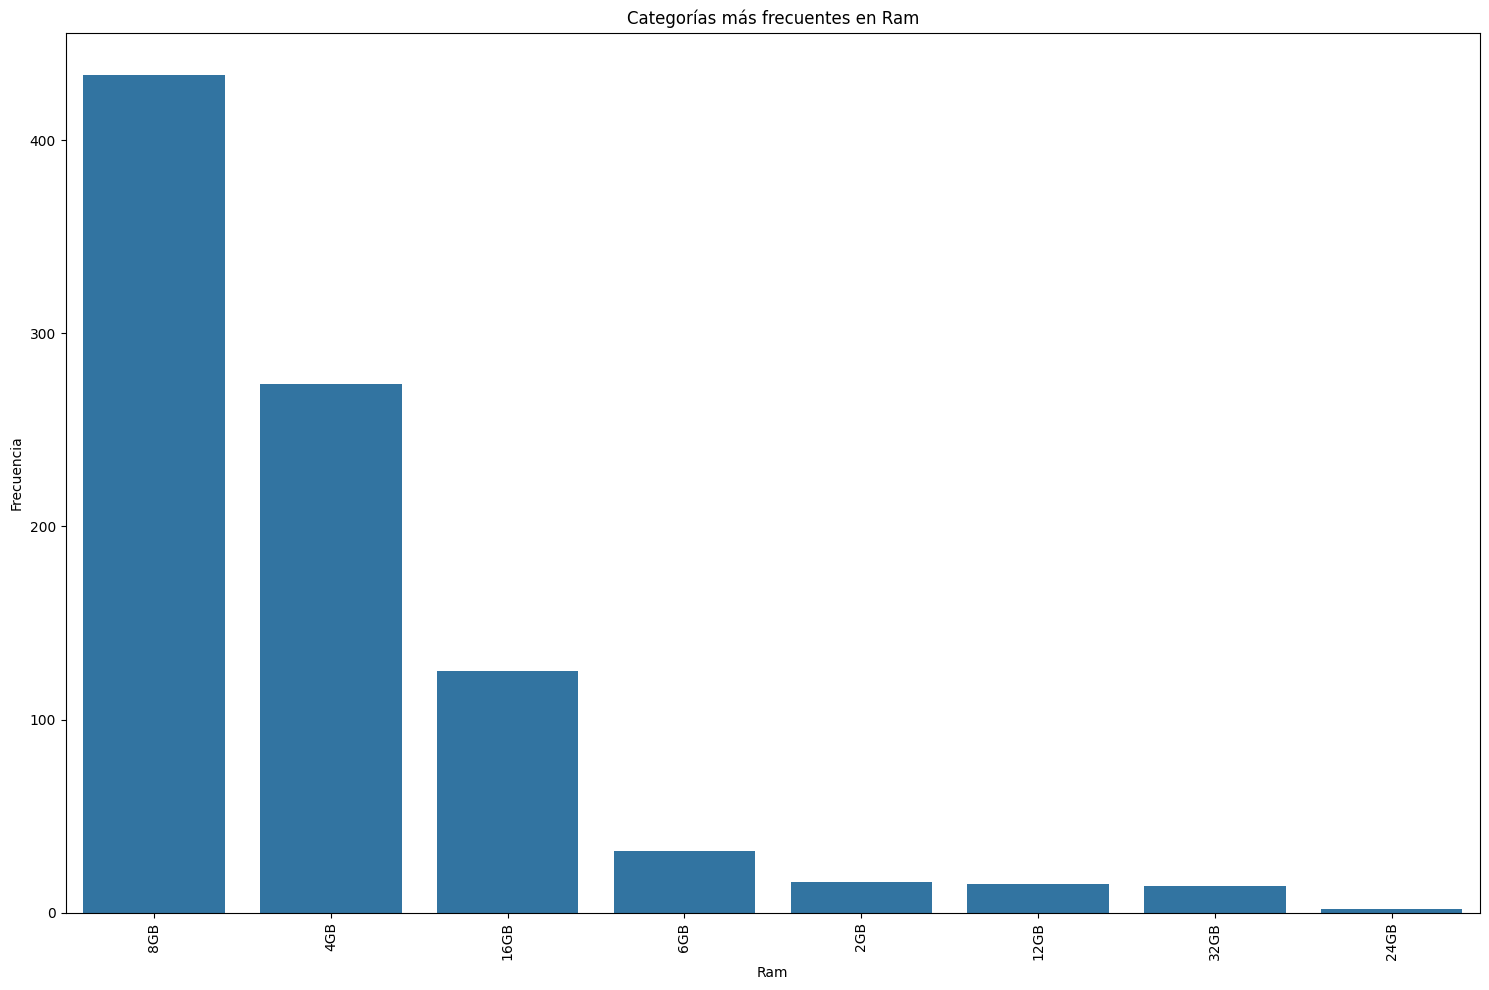

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


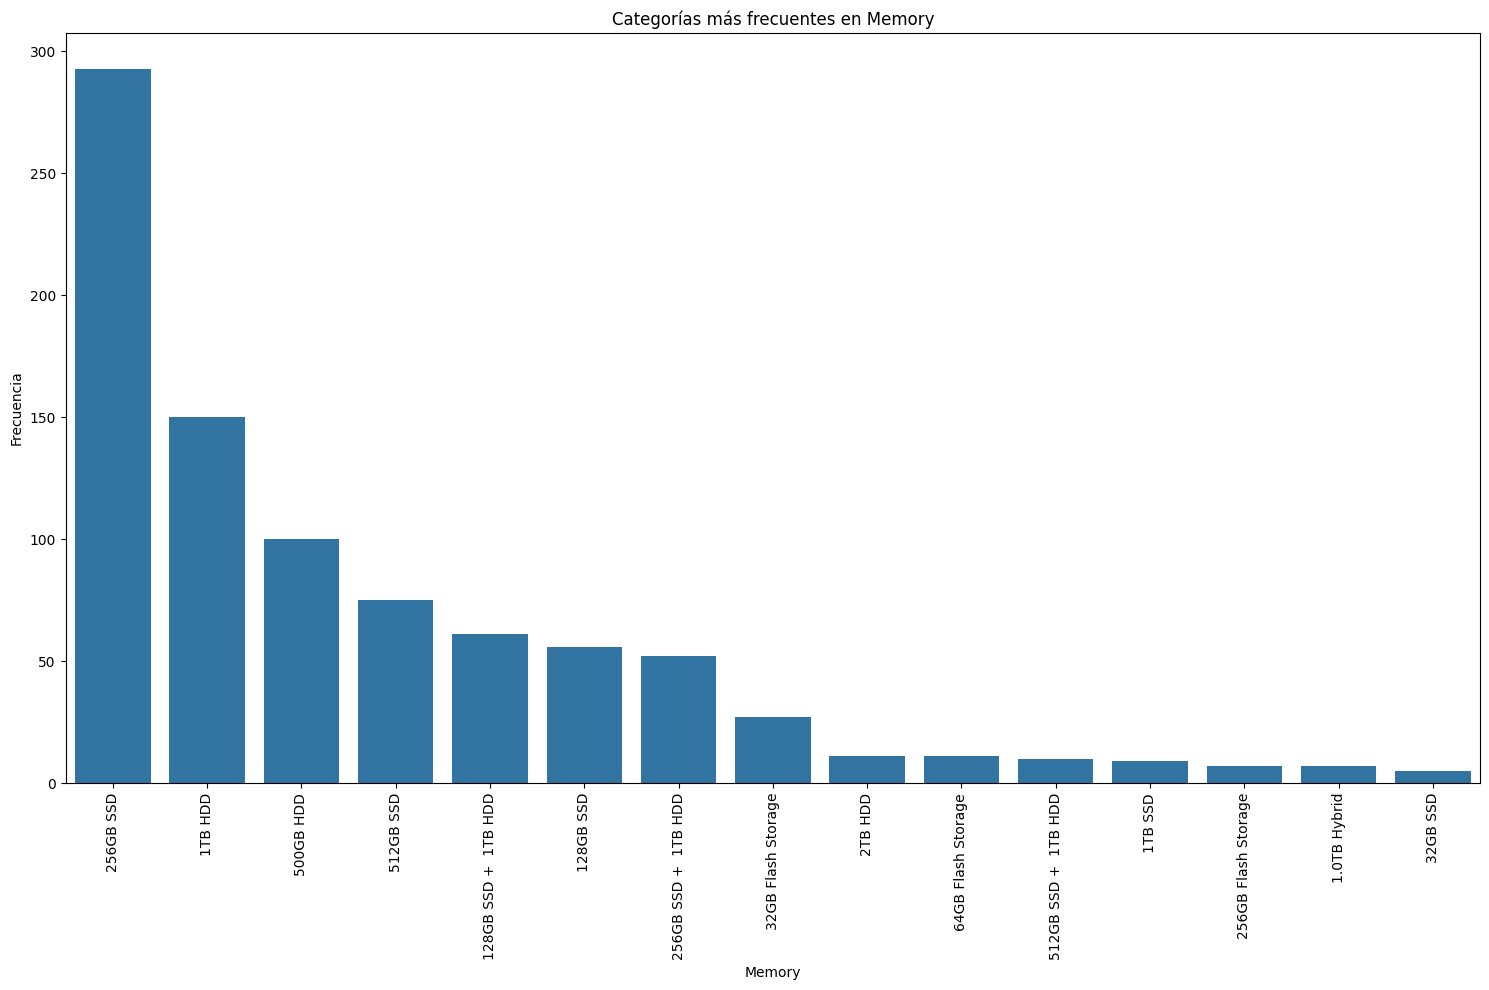

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


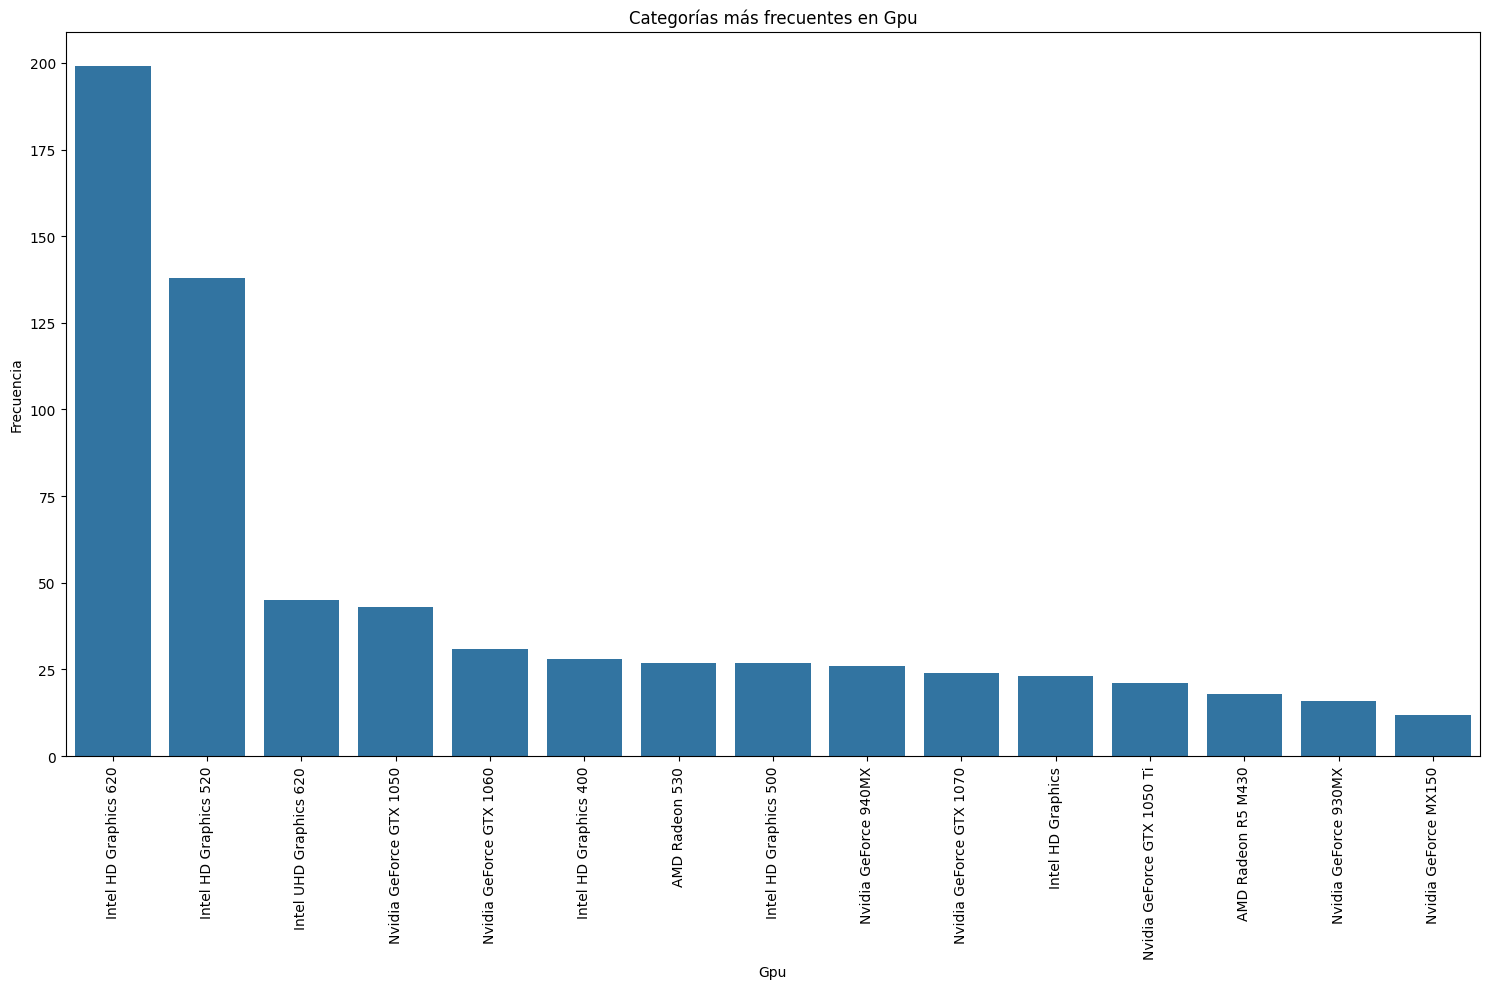

C:\Users\Jon\AppData\Local\Temp\ipykernel_17528\1172245389.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')


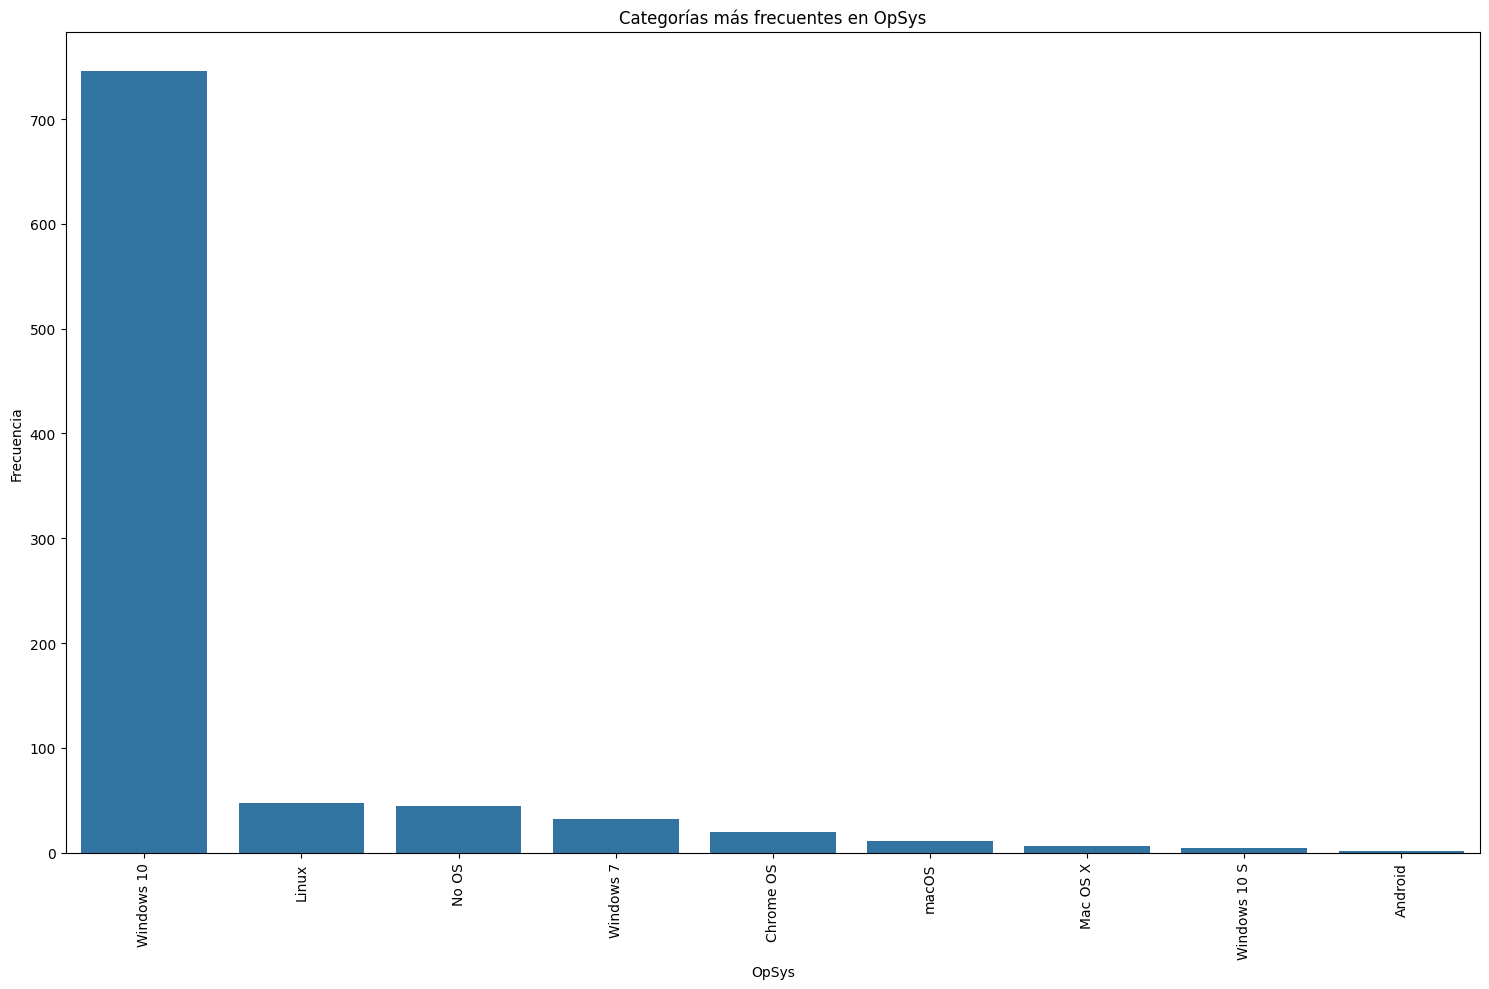

In [895]:
for col in columnas_categoricas:
    plt.figure(figsize=(15, 10))
    top_categories = train[col].value_counts().nlargest(15)
    ax = sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title(f'Categorías más frecuentes en {col}')
    plt.ylabel('Frecuencia')
    plt.xlabel(col)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', va='top')
    
    plt.tight_layout()
    plt.show()

Podemos  observar que algunos grupos predominan claramente sobre otros en ciertas columnas. Por ejemplo, en la columna "Company", marcas como Lenovo, Dell, HP y representan una gran parte del conjunto de datos, reflejando su fuerte presencia en este tipo de mercado. De igual forma, en columnas como "TypeName" (tipo de portátil) y "OpSys" (sistema operativo) , categorías como "Notebook" y "Windows 10" son las más frecuentes. Asi como ciertas caracteristicas como puede ser el caso del tipo de almacenamiento o la resolucion.

Esta concentración en determinados grupos indica que el dataset refleja con bastante precisión la realidad del mercado actual, donde ciertos fabricantes y configuraciones tienen mayor cuota. Para el modelado, esto implica que algunas categorías tendrán más peso y posiblemente más influencia en la predicción de precios. por lo que tenemos que estar atentos para evitar sesgos. 

### Comparativa rápida descriptiva con el conjunto de testeo.

Debido a que el conjunto de test unicamente nos sirve para evaluar el modelo, no para entrenar ni tomar decisiones respecto a la limpieza de las variables no nos interesa hacer un análisis tan exhaustivo del conjunto. Sin embargo sá conviene hacer un análisis rápido con el fin de comprobar que las distribuciones y los rangos no varían respecto al conjunto de entrenamiento, detectar valores nulos u atípicos que puedan estar presentes y verificar que hay consistencia entre ambos datasets. 



In [896]:

def comparativa_eda(train, test):
    print("Información general")
    print("Entrenamiento shape:", train.shape)
    print("Testeo shape:", test.shape)
    
    print("\n Valores nulos")
    print("Entrenamiento:")
    print(train.isnull().sum())
    print("\nTesteo:")
    print(test.isnull().sum())
    
    print("\nTipos de datos")
    print("Entrenamiento:")
    print(train.dtypes)
    print("\nTesteo:")
    print(test.dtypes)
    
    print("\nEstadísticos básicos para variables numéricas")
    print("Entrenamiento:")
    print(train.describe())
    print("\nTesteo:")
    print(test.describe())
    
    print("\nComparación de categorías en variables categóricas")
    categorias = train.select_dtypes(include='object').columns
    for col in categorias:
        print(f"\nColumna: {col}")
        categorias_entr = set(train[col].unique())
        categorias_test = set(test[col].unique())
        print(f"Entrenamiento categorías ({len(categorias_entr)}): {categorias_entr}")
        print(f"Testeo categorías ({len(categorias_test)}): {categorias_test}")
        nuevas_en_test = categorias_test - categorias_entr
        faltantes_en_test = categorias_entr - categorias_test
        if nuevas_en_test:
            print(f"Categorías NUEVAS en test (no vistas en train): {nuevas_en_test}")
        else:
            print("No hay categorías nuevas en test.")
        if faltantes_en_test:
            print(f"Categorías que están en train pero NO en test: {faltantes_en_test}")
        else:
            print("No hay categorías faltantes en test respecto a train.")

comparativa_eda(train, test)

Información general
Entrenamiento shape: (912, 12)
Testeo shape: (391, 11)

 Valores nulos
Entrenamiento:
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Testeo:
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
dtype: int64

Tipos de datos
Entrenamiento:
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight              float64
Price_euros   

Comparando los conjuntos de entrenamiento y prueba se observa que las distribuciones numericas son en general similares, el peso y las pulgadas de pantalla muestran ligeras diferencias en sus rangos:

Al analizar las variables categóricas entre los conjuntos de entrenamiento y prueba, encontramos diferencias importantes en varias columnas.  El conjunto de prueba contiene numerosas categorías de productos que no están presentes en el conjunto de entrenamiento, lo que indica la presencia de valores nuevos o desconocidos para el modelo durante la predicción. Esto puede afectar negativamente la capacidad del modelo para generalizar, ya que no ha visto esos productos durante el entrenamiento y, por lo tanto, no puede asignarles patrones de comportamiento confiables. Por otro lado tambien se detectan valores presentes en entrenamiento que no aparecen en el conjunto de prueba. Esto es menos problemático, ya que no se enfrentan a categorías desconocidas, sino a un subconjunto de las ya conocidas.

### Modelo de Regresion Lineal.

In [909]:
X = train.drop(columns=['Price_euros'])
y = train['Price_euros']

X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(
    X, y, test_size=0.3, random_state=42
)

categorias_ram = sorted(set(X_entrenamiento['Ram'].unique()).union(set(X_validacion['Ram'].unique())))
categorias_memoria = sorted(set(X_entrenamiento['Memory'].unique()).union(set(X_validacion['Memory'].unique())))

print("Ram categories:", categorias_ram)
print("Memory categories:", categorias_memoria)

valores_ordinales = [categorias_ram, categorias_memoria]


categorias_onehot = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
caracteristicas_numericas = ['Inches', 'Weight']


Ram categories: ['12GB', '16GB', '24GB', '2GB', '32GB', '4GB', '6GB', '8GB']
Memory categories: ['1.0TB HDD', '1.0TB Hybrid', '128GB Flash Storage', '128GB SSD', '128GB SSD +  1TB HDD', '128GB SSD +  2TB HDD', '16GB Flash Storage', '16GB SSD', '180GB SSD', '1TB HDD', '1TB HDD +  1TB HDD', '1TB SSD', '1TB SSD +  1TB HDD', '240GB SSD', '256GB Flash Storage', '256GB SSD', '256GB SSD +  1.0TB Hybrid', '256GB SSD +  1TB HDD', '256GB SSD +  256GB SSD', '256GB SSD +  2TB HDD', '256GB SSD +  500GB HDD', '2TB HDD', '32GB Flash Storage', '32GB HDD', '32GB SSD', '500GB HDD', '512GB Flash Storage', '512GB SSD', '512GB SSD +  1.0TB Hybrid', '512GB SSD +  1TB HDD', '512GB SSD +  2TB HDD', '512GB SSD +  512GB SSD', '64GB Flash Storage', '64GB Flash Storage +  1TB HDD', '64GB SSD', '8GB SSD']


Definimos X con todas las columnas del dataframe de entrenamiento a excepción la variable respuesta "Price_euros". Representamos "Y" como la variable que queremos predecir. Seguido dividimos el datas en entrenamiento y prueba, tanto para x como para y. Para este modelo de regresion lineal, se ha decidido que el 30% de estos se dedicaran para prueba, mientras que el 70% restante se empleará para entrenamiento. Además, se ha escogido tambien una semilla (en este caso 42) con el fin de asegurar su reproducibilidad.

Tambien hemos obtenido todas las categorías únicas de 'Ram' y 'Memory' tanto para el dataset de entrenamiento como el de testeo, mas que nada para asegurar que el modelo conozca todas las posibles categorías. Esto nos ha permitido solucionar los diferentes errores al codificar valores que solo aparecen en la validación.

La lista "valores ordinales" es una lista que contiene todos los valores únicos de las columnas mencionadas anteriormente. "Categorias_onehot" por su parte es otra lista de características de carácter mas categórico que van a ser "traducidas", por así decirlo, mediante codificación "one-hot" a variables numéricas, para poder así usarse en modelos que solo aceptan datos numéricos y evitar tambien que dichos modelos asuman un orden entre las distintas categorías. 

In [898]:
preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('num', 'passthrough', numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [899]:
pipeline.fit(X_train_split, y_train_split)
y_pred = pipeline.predict(X_val_split)

mae = mean_absolute_error(y_val_split, y_pred)
print(f"MAE del modelo de Regresión Lineal: {mae:.2f} euros")

MAE del modelo de Regresión Lineal: 269.93 euros


### Modelo de Regresion Polinomica.

In [900]:
X = train.drop(columns=['Price_euros'])
y = train['Price_euros']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.3, random_state=42
)

categorias_ram = sorted(set(X_train_split['Ram'].unique()).union(set(X_val_split['Ram'].unique())))
categorias_memoria = sorted(set(X_train_split['Memory'].unique()).union(set(X_val_split['Memory'].unique())))

ordinal_features = ['Ram', 'Memory']
ordinal_values = [categorias_ram, categorias_memoria]
onehot_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
numeric_features = ['Inches', 'Weight']

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('poly', Pipeline([
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False))
    ]), numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train_split, y_train_split)

y_pred = pipeline.predict(X_val_split)

# Calculamos MAE
mae = mean_absolute_error(y_val_split, y_pred)
print(f"MAE del modelo de regresión polinómica: {mae:.2f} euros")

MAE del modelo de regresión polinómica: 270.37 euros


### Modelo de Decision Tree.

In [901]:
X = train.drop(columns=['Price_euros'])
y = train['Price_euros']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.3, random_state=42
)

categorias_ram = sorted(set(X_train_split['Ram'].unique()).union(set(X_val_split['Ram'].unique())))
categorias_memoria = sorted(set(X_train_split['Memory'].unique()).union(set(X_val_split['Memory'].unique())))

ordinal_features = ['Ram', 'Memory']
ordinal_values = [categorias_ram, categorias_memoria]

onehot_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
numeric_features = ['Inches', 'Weight']

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('num', 'passthrough', numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

pipeline.fit(X_train_split, y_train_split)
y_pred = pipeline.predict(X_val_split)

mae = mean_absolute_error(y_val_split, y_pred)
print(f"MAE del modelo Decision Tree: {mae:.2f} euros")


MAE del modelo Decision Tree: 284.65 euros


### Modelo Random Forest

In [902]:
X = train.drop(columns=['Price_euros'])
y = train['Price_euros']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

ordinal_features = ['Ram', 'Memory']
onehot_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
numeric_features = ['Inches', 'Weight']

categorias_ram = sorted(set(X_train_split['Ram'].unique()).union(set(X_val_split['Ram'].unique())))
categorias_memoria = sorted(set(X_train_split['Memory'].unique()).union(set(X_val_split['Memory'].unique())))
ordinal_values = [categorias_ram, categorias_memoria]

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('num', 'passthrough', numeric_features)
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

pipeline_rf.fit(X_train, y_train)

y_pred = pipeline_rf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE del modelo Random Forest: {mae:.2f} euros")


MAE del modelo Random Forest: 207.69 euros


In [903]:
print(test.columns)


Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight'],
      dtype='object')


### Testeo random Forest

In [904]:
categorias_ram = sorted(set(train['Ram'].unique()).union(set(test['Ram'].unique())))
categorias_memoria = sorted(set(train['Memory'].unique()).union(set(test['Memory'].unique())))

ordinal_features = ['Ram', 'Memory']
ordinal_values = [categorias_ram, categorias_memoria]

onehot_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
numeric_features = ['Inches', 'Weight']

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('num', 'passthrough', numeric_features)
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train = train.drop(columns=['Price_euros'])
y_train = train['Price_euros']

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(test)

submission = pd.DataFrame({
    'id': range(len(test)),   # Creas una columna id con números secuenciales (0,1,2,...)
    'Price_euros': y_pred
})

submission.to_csv('submission.csv', index=False)


In [905]:
sample_sub = pd.read_csv('sample_submission.csv')
y_pred = pipeline_rf.predict(test)

sample_sub['Price_euros'] = y_pred  
sample_sub.to_csv('submission.csv', index=False)

### Testeo con Regresion Lineal

In [906]:
X = train.drop(columns=['Price_euros'])
y = train['Price_euros']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.3, random_state=42
)

categorias_ram = sorted(set(train['Ram'].unique()).union(set(test['Ram'].unique())))
categorias_memoria = sorted(set(train['Memory'].unique()).union(set(test['Memory'].unique())))

ordinal_features = ['Ram', 'Memory']
ordinal_values = [categorias_ram, categorias_memoria]

onehot_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
numeric_features = ['Inches', 'Weight']

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_values), ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_features),
    ('num', 'passthrough', numeric_features)
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train_split, y_train_split)

y_val_pred = pipeline_lr.predict(X_val_split)

In [907]:
pipeline_lr.fit(X, y)  # reentrenar con todo train
y_test_pred = pipeline_lr.predict(test)
sample_sub = pd.read_csv('sample_submission.csv')


submission = pd.DataFrame({
    'id': sample_sub['id'],  # o test['id'] si viene en test.csv
    'Price_euros': y_test_pred
})
submission.to_csv('submission1.csv', index=False)